# Exact diagonalization for the "bow-tie" anti-ferromagnetic Heisenberg model

In [1]:
import numpy  as np
from   qiskit                 import *
from   qiskit.quantum_info    import Pauli
from   qiskit.aqua.operators  import SummedOp,PauliOp
from   qiskit.aqua.algorithms import NumPyEigensolver
import math
import matplotlib 
import matplotlib.pyplot as plt

We want to diagonalize the hamiltonian of the anti-ferromagnetic Heinsenberg model for a "bow-tie" lattice with zero field. The hamiltonian is given by:

$$ H=\sum_{\langle i,j \rangle} \{X_i X_j+Y_iY_j+Z_iZ_j\}$$

where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices acting on site $i$ and $\langle i,j\rangle$ refers to the sum on the nearest neighbours of each site, namely the sum on the couples $\{(0,1),(0,2),(1,2),(2,3),(2,4),(3,4)\}$.

In [2]:
nqubit  = 5
nn_list = [(0,1),(1,2),(0,2),(2,3),(2,4),(3,4)]

### Remark

We note that the $\textbf{WeightedPauliOperator}$ class is deprecated, but it can be substituted with the $\textbf{SummedOp}$ class, in which we insert the $\textbf{PauliOp}$ operators as argument.

We are ready to define our functions.

In [3]:
def generate_pauli(idx_x,idx_z,n):
    '''
    Args:
       n   (integer)
       idx (List)
    Returns:
       tensor product of Pauli operators acting on qubits in idx
       Y = iZX
       P0 P1 P2 P3 P4
       Pi = (X)^a (Z)^b
    '''
    xmask = [0]*n
    zmask = [0]*n
    for i in idx_x: xmask[i] = 1
    for i in idx_z: zmask[i] = 1
    a_x = np.asarray(xmask,dtype=np.bool)
    a_z = np.asarray(zmask,dtype=np.bool)
    return Pauli(a_z,a_x)

#The following function is used to define the operators that appear in the Heisenberg hamiltonian above
#In PauliOp the default coefficient is 1.0
def generate_Heisenberg(nqubit,nn_list):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));    pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit)); pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));    pauli_list.append(zizj)
    H = SummedOp(pauli_list)
    return H

#Here we define the spin operators acting on site i
#We note that this function returns the name of the operator (site+component) and its value
def generate_spin_operators(nqubit):
    spins = []
    for i in range(nqubit):
        xi = generate_pauli([i],[],nqubit);  spins.append( (str(i)+'x',PauliOp(xi,1.0)) )
        yi = generate_pauli([i],[i],nqubit); spins.append( (str(i)+'y',PauliOp(yi,1.0)) )
        zi = generate_pauli([],[i],nqubit);  spins.append( (str(i)+'z',PauliOp(zi,1.0)) )
    return spins

#We note that the argument aux_operators will be the output of function generate_spin_operators
def diagonalize_H(H,aux_operators):
    '''
    k = number of eigenvalues/eigenvectors to find
    H |ci) = Ei |ci)
    Ai = (ci|A|ci)
    aux_ops: list of length k; each element is an array of shape (nprops,2) for real and imaginary part
    '''
    ee = NumPyEigensolver(operator=H,k=2**H.num_qubits,aux_operators=[s for name_s,s in aux_operators])
    ee = ee.run()
    energies = np.real(ee['eigenvalues'])
    psi = ee['eigenstates']
    aux_ops = ee['aux_operator_eigenvalues']
    
    '''
    for i,(ei,ai) in enumerate(zip(energies,aux_ops)):
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        for js,(name_s,s) in enumerate(aux_operators):
            print("     Spin ",name_s,round(ai[js][0],6))  #ai[js] has two arguments: the real and imaginary parts
        print("Eigenvector:")
        psi_i = psi[i].primitive.to_dict()
        for k in psi_i.keys():
            print("     ",k,psi_i[k])
    '''
    return energies,psi,aux_ops

### Example: use of SummedOp and PauliOp

We know show how we can make the composition and the linear combination of Pauli operators using the $\textbf{PauliOp}$ class. If we want to evaluate complex operations like the tensor product of two $\textbf{SummedOp}$ we need to use the $\textbf{.eval()}$ method.

In [4]:
p = PauliOp(generate_pauli([0],[1,2],5))
q = PauliOp(generate_pauli([0,1],[1],5))
r = PauliOp(generate_pauli([1,3],[1],5))
s = PauliOp(generate_pauli([2,3],[1,4],5))

print("Pauli operator p: "+str(p))
print("Pauli operator q: "+str(q))
print("Pauli operator r: "+str(r))
print("Pauli operator s: "+str(s))

print("p@q: "+str((p@q).to_pauli_op()))
print("r@s: "+str((r@s).to_pauli_op()))

pq = (p+q).to_pauli_op()
rs = (r+s).to_pauli_op()
print("p+q: "+str(pq))
print("r+s: "+str(rs))

print("(p+q)@(r+s): "+str((pq@rs).to_pauli_op()))

Pauli operator p: IIZZX
Pauli operator q: IIIYX
Pauli operator r: IXIYI
Pauli operator s: ZXXZI
p@q: -1j * IIZXI
r@s: 1j * ZIXXI
p+q: SummedOp([
  IIZZX,
  IIIYX
])
r+s: SummedOp([
  IXIYI,
  ZXXZI
])
(p+q)@(r+s): SummedOp([
  SummedOp([
    -1j * IXZXX,
    1j * ZXYIX
  ]),
  SummedOp([
    IXIIX,
    1j * ZXXXX
  ])
])


After the definition of the Heisenberg hamiltonian and of the spin operators, we diagonalize it and calculate the expected values on the spin operators.

In [5]:
H = generate_Heisenberg(nqubit,nn_list)
print("Hamiltonian operators:")
print(H)

Hamiltonian operators:
SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])


In [6]:
spins = generate_spin_operators(nqubit)
print("Spin Operators:")
for name_s,s in spins:
    print(name_s+' '+str(s)) 

Spin Operators:
0x IIIIX
0y IIIIY
0z IIIIZ
1x IIIXI
1y IIIYI
1z IIIZI
2x IIXII
2y IIYII
2z IIZII
3x IXIII
3y IYIII
3z IZIII
4x XIIII
4y YIIII
4z ZIIII


In [7]:
output=diagonalize_H(H,spins)

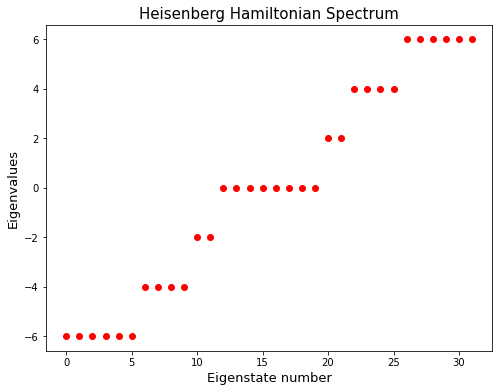

In [33]:
plt.figure(figsize=(8,6))
plt.scatter(np.arange(len(output[0])),output[0],marker="o",color="r")
plt.ylabel("Eigenvalues",size=13)
plt.xlabel("Eigenstate number",size=13)
plt.title("Heisenberg Hamiltonian Spectrum", size=15)
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/Spectrum.pdf")

We can see that the ground state is $\textbf{sixfold}$ degenerate. The spectrum shows also simmetry with respect to the eigenvalues and their degeneration.

## 1) Spin plot of the ground state

Now we look at the spin expectation values on the degenerate ground state and we plot the configuration of the spin in each state.

Before that, we create a function to set the axes scale equal. This helps with the visualization of the spin direction in the eigenstates.

In [9]:
def set_axes_equal(ax):
    '''Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc..  This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    '''

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

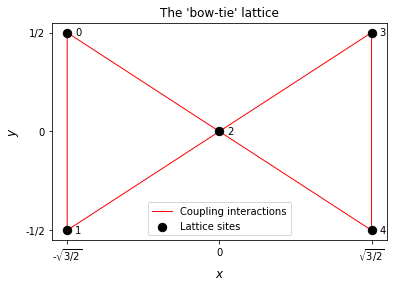

In [27]:
# Make the grid
x=[-0.866,-0.866,0,0.866,0.866]
y=[0.5,-0.5,0,0.5,-0.5]
z=[0,0,0,0,0]

for i,val in enumerate(x):
    plt.annotate(i,(x[i],y[i]), xytext=(x[i]+0.045,y[i]-0.015))
plt.plot(x,y,"r",linewidth="1",label="Coupling interactions",zorder=1)
plt.plot([-0.866,0,0.866],[0.5,0,-0.5],"r",linewidth="1",zorder=1)
plt.scatter(x,y,color="black",s=70,label="Lattice sites",zorder=2)

plt.title("The 'bow-tie' lattice",fontsize=12)
plt.xlabel("$x$",size=12)
plt.xticks([-0.866,0.,0.866],labels=[r"-$\sqrt{3/2}$","0",r"$\sqrt{3/2}$"])
plt.yticks([-0.5,0.,0.5],labels=["-1/2","0","1/2"])
plt.ylabel("$y$",size=12)
plt.legend()
plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/Bowtie.pdf")

Eigenstate number:  0 ; Energy:  -6.0
     Spin  0x 0.035427
     Spin  0y 0.0
     Spin  0z 0.81908
     Spin  1x -0.0
     Spin  1y 0.0
     Spin  1z -0.303089
     Spin  2x -0.01154
     Spin  2y 0.0
     Spin  2z 0.479591
     Spin  3x -0.0185
     Spin  3y 0.0
     Spin  3z 0.045889
     Spin  4x 0.015995
     Spin  4y 0.0
     Spin  4z -0.043113


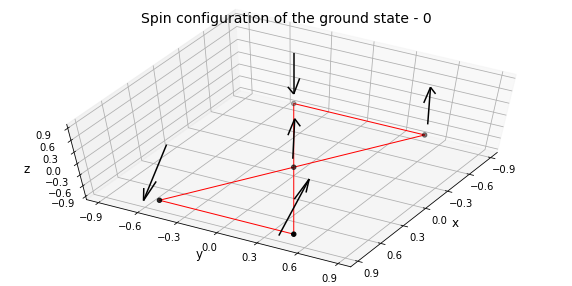

Eigenstate number:  1 ; Energy:  -6.0
     Spin  0x 0.061371
     Spin  0y 0.0
     Spin  0z -0.180611
     Spin  1x 0.221557
     Spin  1y 0.0
     Spin  1z 0.557032
     Spin  2x -0.10472
     Spin  2y 0.0
     Spin  2z 0.090822
     Spin  3x -0.152816
     Spin  3y 0.0
     Spin  3z 0.582448
     Spin  4x 0.028419
     Spin  4y 0.0
     Spin  4z -0.140512


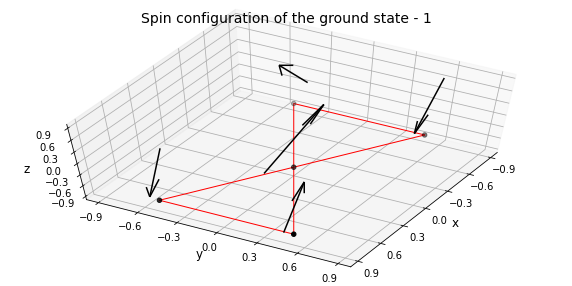

Eigenstate number:  2 ; Energy:  -6.0
     Spin  0x 0.024093
     Spin  0y 0.0
     Spin  0z -0.055064
     Spin  1x -0.238627
     Spin  1y 0.0
     Spin  1z -0.38035
     Spin  2x -0.070861
     Spin  2y 0.0
     Spin  2z 0.226751
     Spin  3x 0.183495
     Spin  3y 0.0
     Spin  3z -0.103034
     Spin  4x 0.032121
     Spin  4y 0.0
     Spin  4z -0.592172


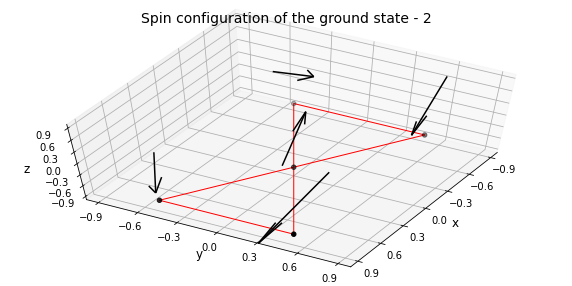

Eigenstate number:  3 ; Energy:  -6.0
     Spin  0x -0.131766
     Spin  0y 0.0
     Spin  0z -0.168022
     Spin  1x 0.017583
     Spin  1y 0.0
     Spin  1z 0.142238
     Spin  2x 0.197676
     Spin  2y 0.0
     Spin  2z -0.009723
     Spin  3x -0.159975
     Spin  3y 0.0
     Spin  3z 0.046389
     Spin  4x -0.074657
     Spin  4y 0.0
     Spin  4z -0.893127


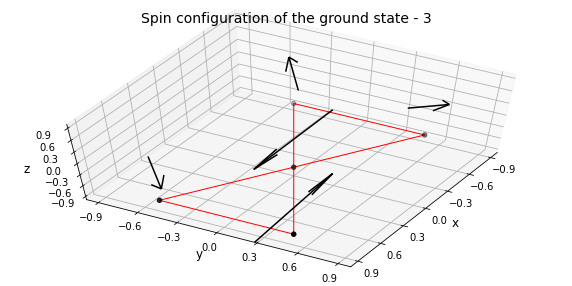

Eigenstate number:  4 ; Energy:  -6.0
     Spin  0x 0.016454
     Spin  0y 0.0
     Spin  0z 0.041408
     Spin  1x 0.006296
     Spin  1y 0.0
     Spin  1z 0.017147
     Spin  2x -0.012251
     Spin  2y 0.0
     Spin  2z -0.328745
     Spin  3x 0.028466
     Spin  3y 0.0
     Spin  3z 0.690826
     Spin  4x 0.002302
     Spin  4y 0.0
     Spin  4z 0.575644


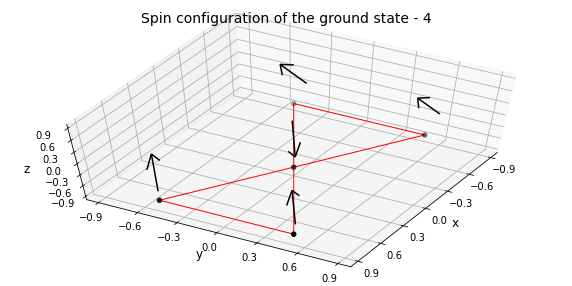

Eigenstate number:  5 ; Energy:  -6.0
     Spin  0x 0.158404
     Spin  0y 0.0
     Spin  0z 0.157144
     Spin  1x -0.315608
     Spin  1y 0.0
     Spin  1z -0.227515
     Spin  2x -0.17899
     Spin  2y 0.0
     Spin  2z -0.373429
     Spin  3x -0.575436
     Spin  3y 0.0
     Spin  3z -0.403688
     Spin  4x 0.17697
     Spin  4y 0.0
     Spin  4z 0.217317


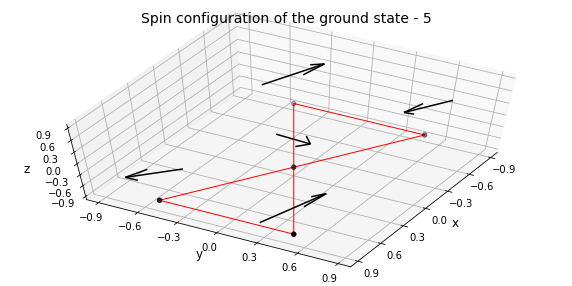

In [62]:
zz=np.zeros(nqubit)
for i in range(nqubit):
    zz[i]=z[i]-0.75

for i,(ei,ai) in enumerate(zip(output[0],output[2])):
    if(i>5):    #the degeneration of the ground state is 6
        break
    u=[]
    v=[]
    w=[]

    print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
    for js,(name_s,s) in enumerate(spins):
        if (js%3)==0:
            u.append(round(ai[js][0],6))
        if (js%3)==1:
            v.append(round(ai[js][0],6))
        if(js%3)==2:
            w.append(round(ai[js][0],6))
        print("     Spin ",name_s,round(ai[js][0],6))

    fig = plt.figure(figsize=(10,5))
    ax = fig.gca(projection='3d')

    ax.quiver(x,y,z,u,v,w,length=1.0,pivot='middle',normalize=True,color="black",zorder=1)
    ax.set_title("Spin configuration of the ground state - "+str(i),size=14)
    ax.set_xlabel("x",size=12)
    ax.set_ylabel("y",size=12)
    ax.set_zlabel("z",size=12)
    ax.set_xticks(np.arange(-0.9,1.,0.3))
    ax.set_yticks(np.arange(-0.9,1.,0.3))
    ax.set_zticks(np.arange(-0.9,1.,0.3))
    ax.view_init(60,30)
    set_axes_equal(ax)

    ax.scatter(x,y,zz,color="black",zorder=2)
    ax.plot(x,y,zz,"r",linewidth="1")
    ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[-0.75,-0.75,-0.75],"r",linewidth="1")

    plt.savefig("/Users/Alecoal/Desktop/Tesi/Text_Thesis/Pictures/GS_config_"+str(i)+".pdf")
    plt.show()

## 2) Evaluation of the spin-spin correlation functions

We now want to study the spin-spin correlation functions, defined as follow:

$$ \langle S_i S_j \rangle_C =\langle S_i S_j \rangle - \langle S_i\rangle \langle S_j \rangle = \langle \sum_{\alpha=\{x,y,z\}} S_i^{\alpha} S_j^{\alpha} \rangle - \langle S_i\rangle \langle S_j \rangle$$

$S_i^{\alpha}$ is the spin operator acting on site $i$ of component $\alpha=\{x,y,z\}$ and the angular brackets refer to an expectation value. The "bow-tie" lattice is composed by $5$ sites, therefore we have to manage $25$ different spin-spin correlation functions. Because of simmetry considerations, we expect that $\langle S_i S_j \rangle_C=\langle S_j S_i \rangle_C$.

Now we show how the $\textbf{.compose()}$ method of the $\textbf{PauliOp}$ class works on two operators acting on $5$ qubits.

### Example:

In [12]:
p = PauliOp(generate_pauli([0],[1,2],5))
q = PauliOp(generate_pauli([0,1],[1],5))
print("p: "+str(p))
print("q: "+str(q))

pp = p.compose(q)
print("p*q: "+str(pp))
pp = q.compose(p)
print("q*p: "+str(pp))

p: IIZZX
q: IIIYX
p*q: -1j * IIZXI
q*p: 1j * IIZXI


In [13]:
def generate_spinspin_operators(nqubit):
    spin_spin=[]
    for i in range(nqubit):
        for j in range(nqubit):
            xi = PauliOp(generate_pauli([i],[],nqubit));
            xj = PauliOp(generate_pauli([j],[],nqubit));
            
            yi = PauliOp(generate_pauli([i],[i],nqubit));
            yj = PauliOp(generate_pauli([j],[j],nqubit));
            
            zi = PauliOp(generate_pauli([],[i],nqubit));
            zj = PauliOp(generate_pauli([],[j],nqubit));
            
            spin_spin.append( (str(i)+'x-'+str(j)+'x',xi.compose(xj)))
            spin_spin.append( (str(i)+'y-'+str(j)+'y',yi.compose(yj)) )
            spin_spin.append( (str(i)+'z-'+str(j)+'z',zi.compose(zj)) )
            
    return spin_spin

In [14]:
spin_spin=generate_spinspin_operators(nqubit)
print("Spin-spin operators number: "+str(len(spin_spin)))
for name_s,s in spin_spin:
    print(name_s+' '+str(s))

Spin-spin operators number: 75
0x-0x IIIII
0y-0y IIIII
0z-0z IIIII
0x-1x IIIXX
0y-1y IIIYY
0z-1z IIIZZ
0x-2x IIXIX
0y-2y IIYIY
0z-2z IIZIZ
0x-3x IXIIX
0y-3y IYIIY
0z-3z IZIIZ
0x-4x XIIIX
0y-4y YIIIY
0z-4z ZIIIZ
1x-0x IIIXX
1y-0y IIIYY
1z-0z IIIZZ
1x-1x IIIII
1y-1y IIIII
1z-1z IIIII
1x-2x IIXXI
1y-2y IIYYI
1z-2z IIZZI
1x-3x IXIXI
1y-3y IYIYI
1z-3z IZIZI
1x-4x XIIXI
1y-4y YIIYI
1z-4z ZIIZI
2x-0x IIXIX
2y-0y IIYIY
2z-0z IIZIZ
2x-1x IIXXI
2y-1y IIYYI
2z-1z IIZZI
2x-2x IIIII
2y-2y IIIII
2z-2z IIIII
2x-3x IXXII
2y-3y IYYII
2z-3z IZZII
2x-4x XIXII
2y-4y YIYII
2z-4z ZIZII
3x-0x IXIIX
3y-0y IYIIY
3z-0z IZIIZ
3x-1x IXIXI
3y-1y IYIYI
3z-1z IZIZI
3x-2x IXXII
3y-2y IYYII
3z-2z IZZII
3x-3x IIIII
3y-3y IIIII
3z-3z IIIII
3x-4x XXIII
3y-4y YYIII
3z-4z ZZIII
4x-0x XIIIX
4y-0y YIIIY
4z-0z ZIIIZ
4x-1x XIIXI
4y-1y YIIYI
4z-1z ZIIZI
4x-2x XIXII
4y-2y YIYII
4z-2z ZIZII
4x-3x XXIII
4y-3y YYIII
4z-3z ZZIII
4x-4x IIIII
4y-4y IIIII
4z-4z IIIII


In [15]:
output2=diagonalize_H(H,spin_spin)

In [16]:
name=[]
for (name_s,s) in spins:
    name.append(name_s)
print(name)

['0x', '0y', '0z', '1x', '1y', '1z', '2x', '2y', '2z', '3x', '3y', '3z', '4x', '4y', '4z']


In the following lines we evaluate the spin-spin correlation functions for the ground state in each degenerate case.

Eigenstate number:  0 ; Energy:  -6.0
Spin-spin correlation values:
     Spin-spin  0-0  2.327854
     Spin-spin  0-1  -1.696869
     Spin-spin  0-2  0.513826
     Spin-spin  0-3  0.020154
     Spin-spin  0-4  -0.098419
     Spin-spin  1-0  -1.696869
     Spin-spin  1-1  2.908137
     Spin-spin  1-2  -2.604148
     Spin-spin  1-3  -0.075714
     Spin-spin  1-4  0.046781
     Spin-spin  2-0  0.513826
     Spin-spin  2-1  -2.604148
     Spin-spin  2-2  2.769859
     Spin-spin  2-3  0.104439
     Spin-spin  2-4  -0.161451
     Spin-spin  3-0  0.020154
     Spin-spin  3-1  -0.075714
     Spin-spin  3-2  0.104439
     Spin-spin  3-3  2.997552
     Spin-spin  3-4  -2.99106
     Spin-spin  4-0  -0.098419
     Spin-spin  4-1  0.046781
     Spin-spin  4-2  -0.161451
     Spin-spin  4-3  -2.99106
     Spin-spin  4-4  2.997885


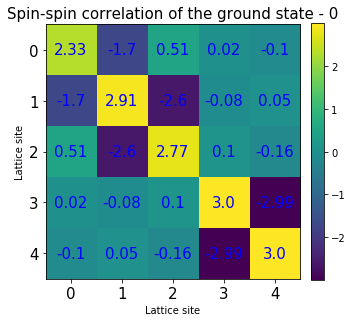

Eigenstate number:  1 ; Energy:  -6.0
Spin-spin correlation values:
     Spin-spin  0-0  2.963613
     Spin-spin  0-1  -1.70167
     Spin-spin  0-2  -1.76163
     Spin-spin  0-3  -0.73998
     Spin-spin  0-4  0.59777
     Spin-spin  1-0  -1.70167
     Spin-spin  1-1  2.640628
     Spin-spin  1-2  0.239407
     Spin-spin  1-3  0.264134
     Spin-spin  1-4  -0.711055
     Spin-spin  2-0  -1.76163
     Spin-spin  2-1  0.239407
     Spin-spin  2-2  2.980785
     Spin-spin  2-3  0.345398
     Spin-spin  2-4  -1.826071
     Spin-spin  3-0  -0.73998
     Spin-spin  3-1  0.264134
     Spin-spin  3-2  0.345398
     Spin-spin  3-3  2.637401
     Spin-spin  3-4  -1.708994
     Spin-spin  4-0  0.59777
     Spin-spin  4-1  -0.711055
     Spin-spin  4-2  -1.826071
     Spin-spin  4-3  -1.708994
     Spin-spin  4-4  2.979449


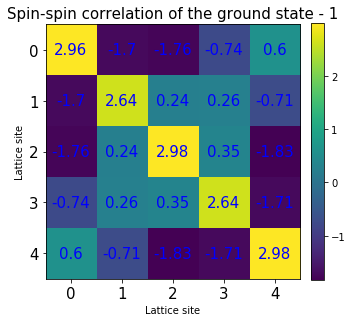

Eigenstate number:  2 ; Energy:  -6.0
Spin-spin correlation values:
     Spin-spin  0-0  2.996388
     Spin-spin  0-1  -1.570798
     Spin-spin  0-2  -1.354232
     Spin-spin  0-3  0.815586
     Spin-spin  0-4  -0.863878
     Spin-spin  1-0  -1.570798
     Spin-spin  1-1  2.798391
     Spin-spin  1-2  -0.222904
     Spin-spin  1-3  -0.922725
     Spin-spin  1-4  0.561953
     Spin-spin  2-0  -1.354232
     Spin-spin  2-1  -0.222904
     Spin-spin  2-2  2.943563
     Spin-spin  2-3  -1.775322
     Spin-spin  2-4  -0.599184
     Spin-spin  3-0  0.815586
     Spin-spin  3-1  -0.922725
     Spin-spin  3-2  -1.775322
     Spin-spin  3-3  2.955714
     Spin-spin  3-4  -0.941176
     Spin-spin  4-0  -0.863878
     Spin-spin  4-1  0.561953
     Spin-spin  4-2  -0.599184
     Spin-spin  4-3  -0.941176
     Spin-spin  4-4  2.6483


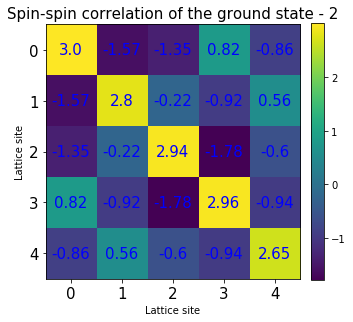

Eigenstate number:  3 ; Energy:  -6.0
Spin-spin correlation values:
     Spin-spin  0-0  2.954406
     Spin-spin  0-1  -2.679428
     Spin-spin  0-2  0.103186
     Spin-spin  0-3  -0.448375
     Spin-spin  0-4  0.221437
     Spin-spin  1-0  -2.679428
     Spin-spin  1-1  2.979459
     Spin-spin  1-2  -0.524986
     Spin-spin  1-3  0.388936
     Spin-spin  1-4  -0.541259
     Spin-spin  2-0  0.103186
     Spin-spin  2-1  -0.524986
     Spin-spin  2-2  2.96083
     Spin-spin  2-3  -2.674857
     Spin-spin  2-4  -0.171426
     Spin-spin  3-0  -0.448375
     Spin-spin  3-1  0.388936
     Spin-spin  3-2  -2.674857
     Spin-spin  3-3  2.972256
     Spin-spin  3-4  -0.513345
     Spin-spin  4-0  0.221437
     Spin-spin  4-1  -0.541259
     Spin-spin  4-2  -0.171426
     Spin-spin  4-3  -0.513345
     Spin-spin  4-4  2.19675


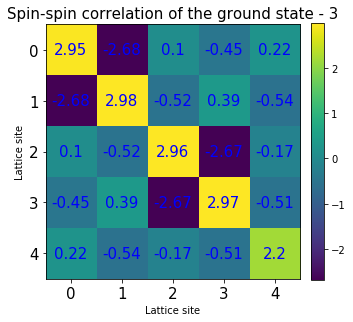

Eigenstate number:  4 ; Energy:  -6.0
Spin-spin correlation values:
     Spin-spin  0-0  2.998015
     Spin-spin  0-1  -2.812357
     Spin-spin  0-2  -0.069446
     Spin-spin  0-3  0.386019
     Spin-spin  0-4  -0.442476
     Spin-spin  1-0  -2.812357
     Spin-spin  1-1  2.999666
     Spin-spin  1-2  -0.139677
     Spin-spin  1-3  -0.429456
     Spin-spin  1-4  0.406312
     Spin-spin  2-0  -0.069446
     Spin-spin  2-1  -0.139677
     Spin-spin  2-2  2.891777
     Spin-spin  2-3  -1.954047
     Spin-spin  2-4  -2.263313
     Spin-spin  3-0  0.386019
     Spin-spin  3-1  -0.429456
     Spin-spin  3-2  -1.954047
     Spin-spin  3-3  2.521949
     Spin-spin  3-4  0.40252
     Spin-spin  4-0  -0.442476
     Spin-spin  4-1  0.406312
     Spin-spin  4-2  -2.263313
     Spin-spin  4-3  0.40252
     Spin-spin  4-4  2.668629


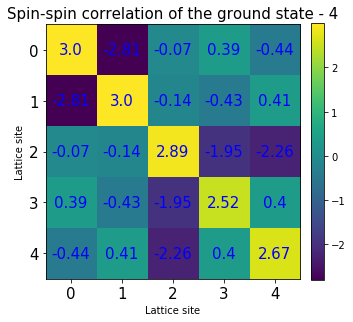

Eigenstate number:  5 ; Energy:  -6.0
Spin-spin correlation values:
     Spin-spin  0-0  2.950214
     Spin-spin  0-1  -2.570102
     Spin-spin  0-2  -1.23546
     Spin-spin  0-3  -0.569711
     Spin-spin  0-4  0.350338
     Spin-spin  1-0  -2.570102
     Spin-spin  1-1  2.848628
     Spin-spin  1-2  0.465236
     Spin-spin  1-3  0.139391
     Spin-spin  1-4  -0.52191
     Spin-spin  2-0  -1.23546
     Spin-spin  2-1  0.465236
     Spin-spin  2-2  2.828513
     Spin-spin  2-3  0.466033
     Spin-spin  2-4  -2.192869
     Spin-spin  3-0  -0.569711
     Spin-spin  3-1  0.139391
     Spin-spin  3-2  0.466033
     Spin-spin  3-3  2.505909
     Spin-spin  3-4  -1.877305
     Spin-spin  4-0  0.350338
     Spin-spin  4-1  -0.52191
     Spin-spin  4-2  -2.192869
     Spin-spin  4-3  -1.877305
     Spin-spin  4-4  2.921455


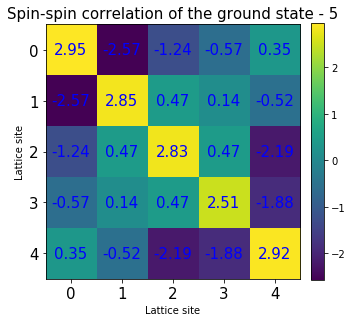

In [17]:
#We print the values of the spin-spin correlation functions for the gs also on an output file.
out_spinspin = open("spinspin_corr.out","w")

for i,(ei,ai,a2i) in enumerate(zip(output[0],output[2],output2[2])):
        if(i>5):    #the degeneration of the ground state is 6
            break
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        print("Spin-spin correlation values:")
        
        ss=[0]*(nqubit*nqubit)
        s=[0]*(nqubit*nqubit)
        M=np.zeros((nqubit,nqubit))
        
        n=0
        p=0
        for j in range(nqubit):
            for k in range(nqubit):
                sj=0
                sk=0
                for l in range(3):
                    ss[p] += a2i[n][0]
                    sj+=ai[3*j+l][0]**2
                    sk+=ai[3*k+l][0]**2
                    n += 1
                
                s[p]=pow(sj,0.5)*pow(sk,0.5)
                M[j,k]=ss[p]-s[p]
                print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
                
                if i==0:   #Here we just print the spin-spin correlation values for the ground state -0
                    out_spinspin.write(str(j)+"-"+str(k)+" "+str(round(ss[p]-s[p],6))+"\n")
                p+=1

        #Here we create a visual representation of the spin-spin correlation values
        fig, ax = plt.subplots(figsize=(5,10))
        im = ax.imshow(M)
        
        ax.set_xticks(np.arange(nqubit))
        ax.set_yticks(np.arange(nqubit))
        ax.set_xticklabels(np.arange(nqubit), fontsize=15)
        ax.set_yticklabels(np.arange(nqubit), fontsize=15)

        ax.set_xlabel("Lattice site")
        ax.set_ylabel("Lattice site")
        
        fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

        for ii in range(nqubit):
            for jj in range(nqubit):
                text = ax.text(jj, ii, round(M[ii, jj],2),
                               ha="center", va="center", color="b", fontsize=15)

        ax.set_title("Spin-spin correlation of the ground state - "+str(i), fontsize=15)
        fig.tight_layout()
        plt.show()
        
            
out_spinspin.close()

## 3) Transverse-field Ising model 

We want to diagonalize the hamiltonian of the Ising model for a "bow-tie" lattice with an external transverse-field. The hamiltonian is given by:
 
$$ H=\sum_{\langle i,j \rangle} \{gZ_iZ_j + X_i + X_j\}$$

where $X_i$ and $Z_i$ are the Pauli matrices acting on site $i$ on $x$ and $z$ component, respectively. $\langle i,j\rangle$ refers to the sum on the nearest neighbours of each site, namely the sum on the couples $\{(0,1),(0,2),(1,2),(2,3),(2,4),(3,4)\}$.

In [18]:
def generate_Ising(nqubit,nn_list,g):
    pauli_list = []
    for (i,j) in nn_list:
        zizj = PauliOp(generate_pauli([],[i,j],nqubit),g);    pauli_list.append(zizj)
        xi=PauliOp(generate_pauli([i],[],nqubit));            pauli_list.append(xi)
        xj=PauliOp(generate_pauli([j],[],nqubit));            pauli_list.append(xj)
    H = SummedOp(pauli_list)
    return H

In the following we will consider as auxiliary operators also the y-component Pauli matrices, even if we know that the expectation value will be zero in each site of the "bow-tie" lattice.

### Case A - g=0.1

In [19]:
H_I = generate_Ising(nqubit,nn_list,0.1)
print("Hamiltonian operators:")
print(H_I)

Hamiltonian operators:
SummedOp([
  0.1 * IIIZZ,
  IIIIX,
  IIIXI,
  0.1 * IIZZI,
  IIIXI,
  IIXII,
  0.1 * IIZIZ,
  IIIIX,
  IIXII,
  0.1 * IZZII,
  IIXII,
  IXIII,
  0.1 * ZIZII,
  IIXII,
  XIIII,
  0.1 * ZZIII,
  IXIII,
  XIIII
])


In [20]:
output3=diagonalize_H(H_I,spins)

Text(0.5, 1.0, 'Bow-tie Ising Model Spectrum')

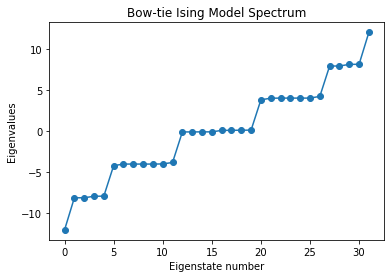

In [21]:
plt.plot(np.arange(len(output3[0])),output3[0],marker="o")
plt.ylabel("Eigenvalues")
plt.xlabel("Eigenstate number")
plt.title("Bow-tie Ising Model Spectrum")

We see that the spectrum has a "stairs" shape, namely the eigenvalues are divided in groups gapped one from the other.  

Eigenstate number:  0 ; Energy:  -12.005724
GROUND STATE
     Spin  0x -0.999565
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x -0.999565
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.999467
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.999565
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.999565
     Spin  4y 0.0
     Spin  4z 0.0


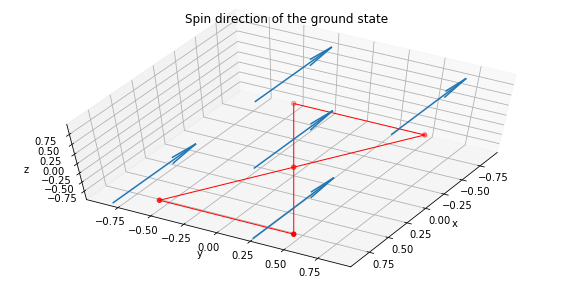

Eigenstate number:  1 ; Energy:  -8.102861
     Spin  0x -0.928909
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x -0.928909
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.999734
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.070656
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.070656
     Spin  4y 0.0
     Spin  4z 0.0


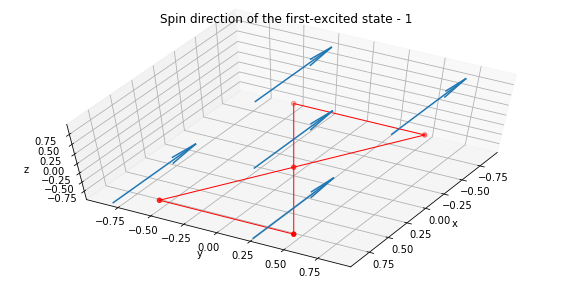

Eigenstate number:  2 ; Energy:  -8.102861
     Spin  0x -0.239147
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x -0.239147
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.999734
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.760418
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.760418
     Spin  4y 0.0
     Spin  4z 0.0


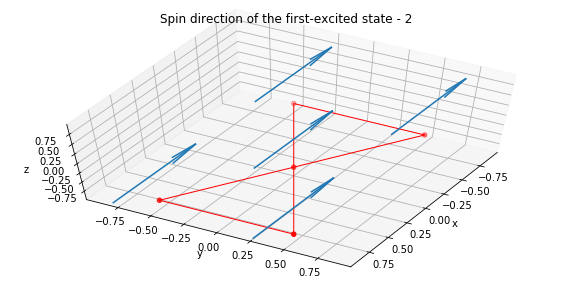

In [22]:
for i,(ei,ai) in enumerate(zip(output3[0],output3[2])):
        if(i>2):     #We want to consider the ground state and the first excited states
            break
        u=[]
        v=[]
        w=[]
        
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        if i==0:
            print("GROUND STATE")
        for js,(name_s,s) in enumerate(spins):
            if (js%3)==0:
                u.append(round(ai[js][0],6))
            if (js%3)==1:
                v.append(round(ai[js][0],6))
            if(js%3)==2:
                w.append(round(ai[js][0],6))
                
            print("     Spin ",name_s,round(ai[js][0],6))
       
        fig = plt.figure(figsize=(10,5))
        ax = fig.gca(projection='3d')

        ax.quiver(x,y,z,u,v,w,length=1.0, pivot='middle', normalize=True)
        if i==0:
            ax.set_title("Spin direction of the ground state")
        else:
            ax.set_title("Spin direction of the first-excited state - "+str(i))
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(60,30)
        set_axes_equal(ax)
        
        ax.scatter(x,y,zz,color="r")
        ax.plot(x,y,zz,"r",linewidth="1")
        ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[-0.75,-0.75,-0.75],"r",linewidth="1")

        plt.show()

### Case B - g=1

In [23]:
H_I = generate_Ising(nqubit,nn_list,1.0)
print("Hamiltonian operators:")
print(H_I)

Hamiltonian operators:
SummedOp([
  IIIZZ,
  IIIIX,
  IIIXI,
  IIZZI,
  IIIXI,
  IIXII,
  IIZIZ,
  IIIIX,
  IIXII,
  IZZII,
  IIXII,
  IXIII,
  ZIZII,
  IIXII,
  XIIII,
  ZZIII,
  IXIII,
  XIIII
])


In [24]:
output3=diagonalize_H(H_I,spins)

Text(0.5, 1.0, 'Bow-tie Ising Model Spectrum')

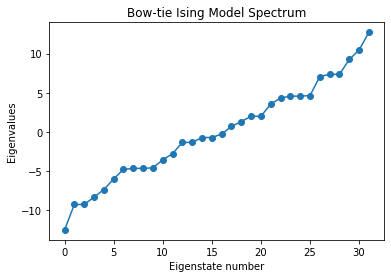

In [25]:
plt.plot(np.arange(len(output3[0])),output3[0],marker="o")
plt.ylabel("Eigenvalues")
plt.xlabel("Eigenstate number")
plt.title("Bow-tie Ising Model Spectrum")

Eigenstate number:  0 ; Energy:  -12.483638
GROUND STATE
     Spin  0x -0.968957
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x -0.968957
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.963483
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.968957
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.968957
     Spin  4y 0.0
     Spin  4z 0.0


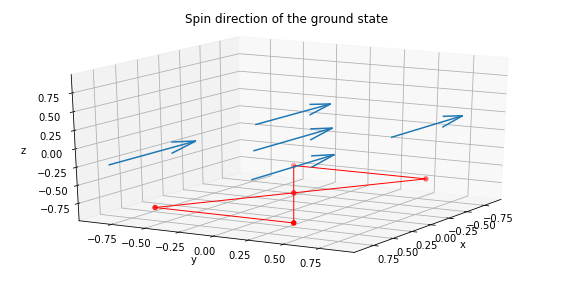

Eigenstate number:  1 ; Energy:  -9.240152
     Spin  0x -0.966053
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x -0.966053
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.982081
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.003394
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.003394
     Spin  4y 0.0
     Spin  4z 0.0


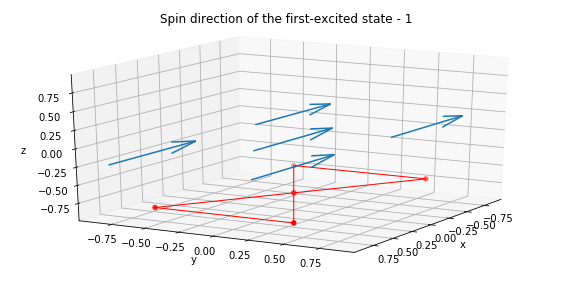

Eigenstate number:  2 ; Energy:  -9.240152
     Spin  0x -0.006702
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x -0.006702
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.982081
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.962745
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.962745
     Spin  4y 0.0
     Spin  4z 0.0


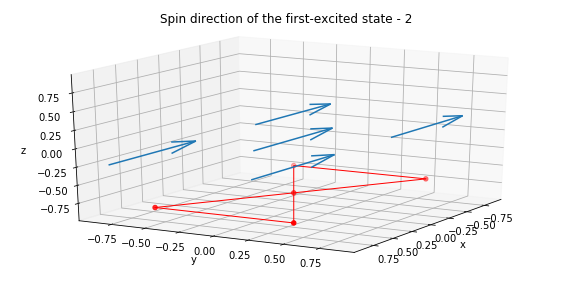

In [26]:
for i,(ei,ai) in enumerate(zip(output3[0],output3[2])):
        if(i>2):     #We want to consider the ground state and the first excited states
            break
        u=[]
        v=[]
        w=[]
        
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        if i==0:
            print("GROUND STATE")
        for js,(name_s,s) in enumerate(spins):
            if (js%3)==0:
                u.append(round(ai[js][0],6))
            if (js%3)==1:
                v.append(round(ai[js][0],6))
            if(js%3)==2:
                w.append(round(ai[js][0],6))
            
            print("     Spin ",name_s,round(ai[js][0],6))
       
        fig = plt.figure(figsize=(10,5))
        ax = fig.gca(projection='3d')

        ax.quiver(x,y,z,u,v,w,length=1.0,pivot='middle', normalize=True)
        if i==0:
            ax.set_title("Spin direction of the ground state")
        else:
            ax.set_title("Spin direction of the first-excited state - "+str(i))
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(20,30)
        set_axes_equal(ax)
        
        ax.scatter(x,y,zz,color="r")
        ax.plot(x,y,zz,"r",linewidth="1")
        ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[-0.75,-0.75,-0.75],"r",linewidth="1")

        plt.show()

### Case C - g=10

In [27]:
H_I = generate_Ising(nqubit,nn_list,10)
print("Hamiltonian operators:")
print(H_I)

Hamiltonian operators:
SummedOp([
  10 * IIIZZ,
  IIIIX,
  IIIXI,
  10 * IIZZI,
  IIIXI,
  IIXII,
  10 * IIZIZ,
  IIIIX,
  IIXII,
  10 * IZZII,
  IIXII,
  IXIII,
  10 * ZIZII,
  IIXII,
  XIIII,
  10 * ZZIII,
  IXIII,
  XIIII
])


In [28]:
output3=diagonalize_H(H_I,spins)

Text(0.5, 1.0, 'Bow-tie Ising Model Spectrum')

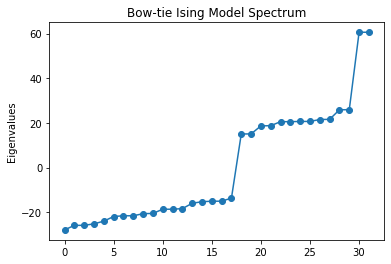

In [29]:
plt.plot(np.arange(len(output3[0])),output3[0],marker="o")
plt.ylabel("Eigenvalues")
plt.title("Bow-tie Ising Model Spectrum")

Eigenstate number:  0 ; Energy:  -27.926602
GROUND STATE
     Spin  0x -0.731027
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x -0.731027
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.680458
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.731027
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.731027
     Spin  4y 0.0
     Spin  4z 0.0


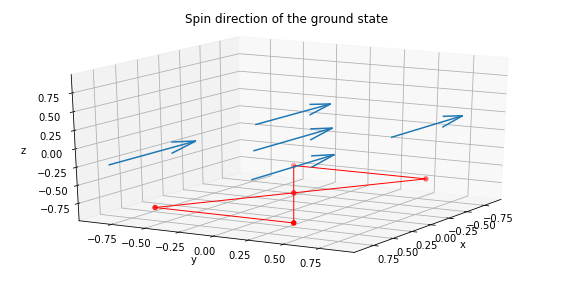

Eigenstate number:  1 ; Energy:  -25.882936
     Spin  0x -0.049467
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x -0.049467
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.849706
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.663308
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.663308
     Spin  4y 0.0
     Spin  4z 0.0


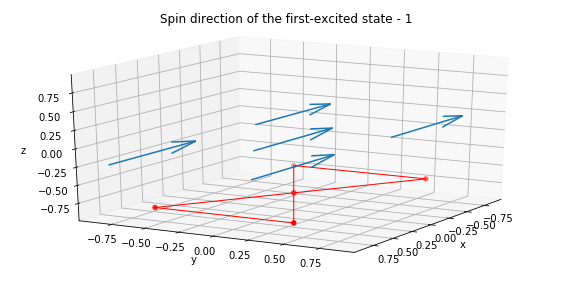

Eigenstate number:  2 ; Energy:  -25.882936
     Spin  0x -0.6931
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x -0.6931
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x -0.849706
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.019675
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.019675
     Spin  4y 0.0
     Spin  4z 0.0


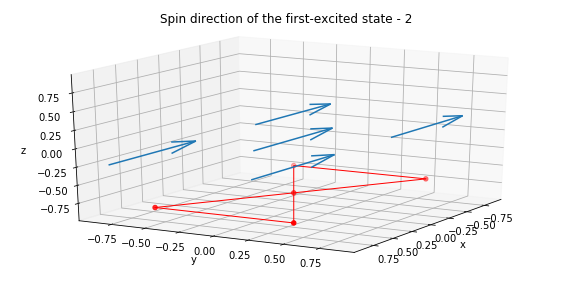

In [30]:
for i,(ei,ai) in enumerate(zip(output3[0],output3[2])):
        if(i>2):     #We want to consider the ground state and the first excited states
            break
        u=[]
        v=[]
        w=[]
        
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        if i==0:
            print("GROUND STATE")
        for js,(name_s,s) in enumerate(spins):
            if (js%3)==0:
                u.append(round(ai[js][0],6))
            if (js%3)==1:
                v.append(round(ai[js][0],6))
            if(js%3)==2:
                w.append(round(ai[js][0],6))
        
            print("     Spin ",name_s,round(ai[js][0],6))
       
        fig = plt.figure(figsize=(10,5))
        ax = fig.gca(projection='3d')

        ax.quiver(x,y,z,u,v,w,length=1.0,pivot='middle', normalize=True)
        if i==0:
            ax.set_title("Spin direction of the ground state")
        else:
            ax.set_title("Spin direction of the first-excited state - "+str(i))
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(20,30)
        set_axes_equal(ax)
        
        ax.scatter(x,y,zz,color="r")
        ax.plot(x,y,zz,"r",linewidth="1")
        ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[-0.75,-0.75,-0.75],"r",linewidth="1")

        plt.show()

### Questions

- Why do the spins follow the same direction in all the cases ($g=0.1,1.0,10.0$)?
- Is this fact linked with the freedom of the spin vector to move on the $y-z$ plane? 

## 4) Transverse-field anti-ferromagnetic Heisenberg Model

We now want to analize the case in which we have an Heisenberg hamiltonian with an external transverse-field. In particular we will consider the external field acting only on the site $0$.

$$ H=\sum_{\langle i,j \rangle} \{X_i X_j+Y_iY_j+Z_iZ_j\} + hX_0$$

where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices acting on site $i$, $\langle i,j\rangle$ refers to the sum on the nearest neighbours of each site, namely the sum on the couples $\{(0,1),(0,2),(1,2),(2,3),(2,4),(3,4)\}$, and $h$ is the applied magnetic field.

In [31]:
def generate_Heisenberg_transverse(nqubit,nn_list,h):
    pauli_list = []
    for (i,j) in nn_list:
        xixj = PauliOp(generate_pauli([i,j],[],nqubit));      pauli_list.append(xixj)
        yiyj = PauliOp(generate_pauli([i,j],[i,j],nqubit));   pauli_list.append(yiyj)
        zizj = PauliOp(generate_pauli([],[i,j],nqubit));      pauli_list.append(zizj)
    x0 = PauliOp(generate_pauli([0],[],nqubit),h);            pauli_list.append(x0)
    H = SummedOp(pauli_list)
    return H

### Case  h=1.0

In [32]:
H_t = generate_Heisenberg_transverse(nqubit,nn_list,1.0)
print("Transverse-field anti-ferromagnetic Hamiltonian operators:")
print(H_t)

Transverse-field anti-ferromagnetic Hamiltonian operators:
SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII,
  IIIIX
])


In [33]:
output4=diagonalize_H(H_t,spins)

Text(0.5, 1.0, 'Bow-tie transverse-field Heisenberg Model Spectrum')

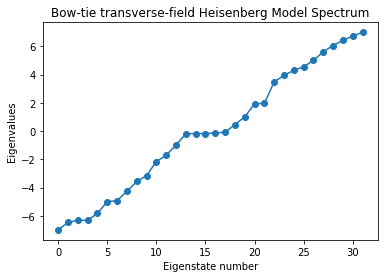

In [34]:
plt.plot(np.arange(len(output4[0])),output4[0],marker="o")
plt.ylabel("Eigenvalues")
plt.xlabel("Eigenstate number")
plt.title("Bow-tie transverse-field Heisenberg Model Spectrum")

We immediately observe that the introduction of the external field removes the degeneration on the ground state of the original hamiltonian with zero-field. Therefore we can state that we just observed a broken simmetry.

Eigenstate number:  1 ; Energy:  -7.0
GROUND STATE
     Spin  0x -1.0
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x 0.0
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x 0.0
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 0.0


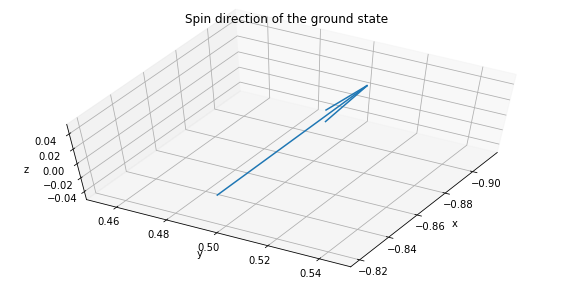

Eigenstate number:  2 ; Energy:  -6.464102
     Spin  0x -0.5773502691896255
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x 0.7886751345948124
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x 0.7886751345948129
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x 0.0
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x 0.0
     Spin  4y 0.0
     Spin  4z 0.0


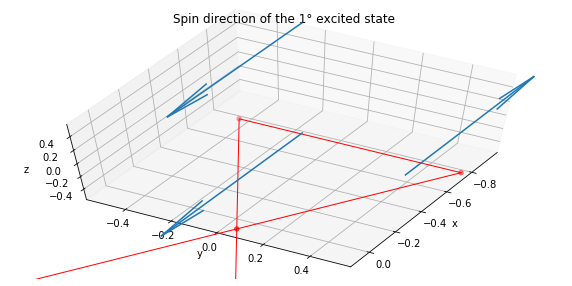

Eigenstate number:  3 ; Energy:  -6.323266
     Spin  0x -0.5846426643186979
     Spin  0y 0.0
     Spin  0z 0.0
     Spin  1x 0.5582147696117399
     Spin  1y 0.0
     Spin  1z 0.0
     Spin  2x 0.31902420460560177
     Spin  2y 0.0
     Spin  2z 0.0
     Spin  3x -0.6462981549493214
     Spin  3y 0.0
     Spin  3z 0.0
     Spin  4x -0.6462981549493225
     Spin  4y 0.0
     Spin  4z 0.0


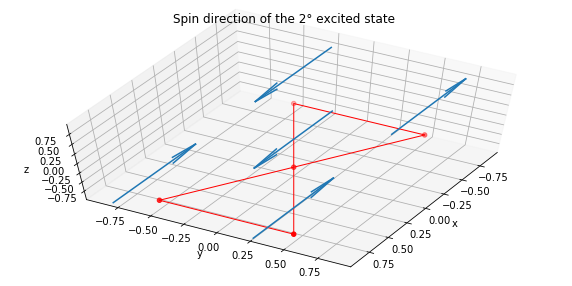

In [35]:
for i,(ei,ai) in enumerate(zip(output4[0],output4[2])):
        if(i>2):     #We want to consider the ground state and the first excited states
            break
        u=[]
        v=[]
        w=[]
        
        print("Eigenstate number: ",i+1,"; Energy: ",round(ei,6))
        if i==0:
            print("GROUND STATE")
        for js,(name_s,s) in enumerate(spins):
            if (js%3)==0:
                u.append(ai[js][0])
            if (js%3)==1:
                v.append(ai[js][0])
            if(js%3)==2:
                w.append(ai[js][0])
            print("     Spin ",name_s,ai[js][0])
       
        fig = plt.figure(figsize=(10,5))
        ax = fig.gca(projection='3d')

        if i==0:
            ax.set_title("Spin direction of the ground state")
            ax.quiver(x,y,z,u,v,w,length=0.1,pivot='middle',normalize=True)
        else:
            ax.set_title("Spin direction of the "+str(i)+"° excited state ")
            ax.quiver(x,y,z,u,v,w,length=1.0,pivot='middle',normalize=True)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_zlabel("z")
        ax.view_init(60,30)
        set_axes_equal(ax)
        
        ax.scatter(x,y,zz,color="r")
        ax.plot(x,y,zz,"r",linewidth="1")
        ax.plot([-0.866,0,0.866],[0.5,0,-0.5],[-0.75,-0.75,-0.75],"r",linewidth="1")

        plt.show()

We want the expectation values on spin-spin operators in order to get the spin-spin correlation functions.

In [36]:
output5=diagonalize_H(H_t,spin_spin)

Eigenstate number:  0 ; Energy:  -7.0
Spin-spin correlation values:
     Spin-spin  0-0  2.0
     Spin-spin  0-1  0.0
     Spin-spin  0-2  0.0
     Spin-spin  0-3  0.0
     Spin-spin  0-4  0.0
     Spin-spin  1-0  0.0
     Spin-spin  1-1  3.0
     Spin-spin  1-2  -3.0
     Spin-spin  1-3  0.0
     Spin-spin  1-4  0.0
     Spin-spin  2-0  0.0
     Spin-spin  2-1  -3.0
     Spin-spin  2-2  3.0
     Spin-spin  2-3  0.0
     Spin-spin  2-4  0.0
     Spin-spin  3-0  0.0
     Spin-spin  3-1  0.0
     Spin-spin  3-2  0.0
     Spin-spin  3-3  3.0
     Spin-spin  3-4  -3.0
     Spin-spin  4-0  0.0
     Spin-spin  4-1  0.0
     Spin-spin  4-2  0.0
     Spin-spin  4-3  -3.0
     Spin-spin  4-4  3.0


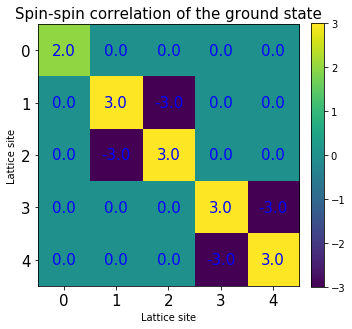

Eigenstate number:  1 ; Energy:  -6.464102
Spin-spin correlation values:
     Spin-spin  0-0  2.666667
     Spin-spin  0-1  -2.398717
     Spin-spin  0-2  -2.398717
     Spin-spin  0-3  0.0
     Spin-spin  0-4  0.0
     Spin-spin  1-0  -2.398717
     Spin-spin  1-1  2.377992
     Spin-spin  1-2  0.377992
     Spin-spin  1-3  0.0
     Spin-spin  1-4  0.0
     Spin-spin  2-0  -2.398717
     Spin-spin  2-1  0.377992
     Spin-spin  2-2  2.377992
     Spin-spin  2-3  0.0
     Spin-spin  2-4  0.0
     Spin-spin  3-0  0.0
     Spin-spin  3-1  0.0
     Spin-spin  3-2  0.0
     Spin-spin  3-3  3.0
     Spin-spin  3-4  -3.0
     Spin-spin  4-0  0.0
     Spin-spin  4-1  0.0
     Spin-spin  4-2  0.0
     Spin-spin  4-3  -3.0
     Spin-spin  4-4  3.0


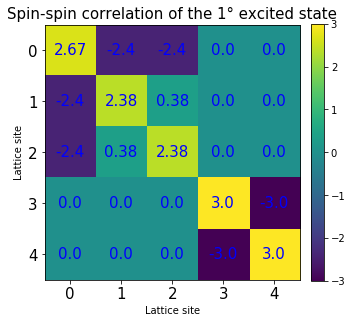

Eigenstate number:  2 ; Energy:  -6.323266
Spin-spin correlation values:
     Spin-spin  0-0  2.658193
     Spin-spin  0-1  -2.861155
     Spin-spin  0-2  -0.441719
     Spin-spin  0-3  -0.08287
     Spin-spin  0-4  -0.08287
     Spin-spin  1-0  -2.861155
     Spin-spin  1-1  2.688396
     Spin-spin  1-2  -0.19376
     Spin-spin  1-3  -0.458457
     Spin-spin  1-4  -0.458457
     Spin-spin  2-0  -0.441719
     Spin-spin  2-1  -0.19376
     Spin-spin  2-2  2.898224
     Spin-spin  2-3  -2.172657
     Spin-spin  2-4  -2.172657
     Spin-spin  3-0  -0.08287
     Spin-spin  3-1  -0.458457
     Spin-spin  3-2  -2.172657
     Spin-spin  3-3  2.582299
     Spin-spin  3-4  0.582299
     Spin-spin  4-0  -0.08287
     Spin-spin  4-1  -0.458457
     Spin-spin  4-2  -2.172657
     Spin-spin  4-3  0.582299
     Spin-spin  4-4  2.582299


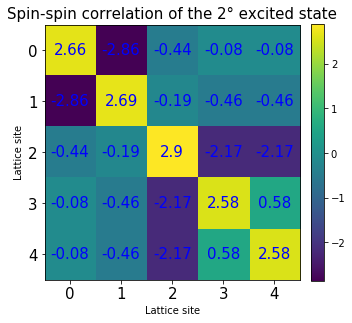

In [37]:
for i,(ei,ai,a2i) in enumerate(zip(output4[0],output4[2],output5[2])):
        if(i>2):    #the degeneration of the ground state is 6
            break
        print("Eigenstate number: ",i,"; Energy: ",round(ei,6))
        print("Spin-spin correlation values:")
        
        ss=[0]*(nqubit*nqubit)
        s=[0]*(nqubit*nqubit)
        
        n=0
        p=0
        for j in range(nqubit):
            for k in range(nqubit):
                sj=0
                sk=0
                for l in range(3):
                    ss[p] += a2i[n][0]
                    sj+=ai[3*j+l][0]**2
                    sk+=ai[3*k+l][0]**2
                    n += 1
                s[p]=pow(sj,0.5)*pow(sk,0.5)
                
                print("     Spin-spin ",str(j)+"-"+str(k)+" ",round(ss[p]-s[p],6))
                p+=1

        #Here we create a visual representation of the spin-spin correlation values
        M=np.zeros((nqubit,nqubit))
        q=0
        for ii in range(nqubit):
            for jj in range(nqubit):
                M[ii,jj]=ss[q]-s[q]
                q+=1

        fig, ax = plt.subplots(figsize=(5,10))
        im = ax.imshow(M)
        
        ax.set_xticks(np.arange(nqubit))
        ax.set_yticks(np.arange(nqubit))
        ax.set_xticklabels(np.arange(nqubit), fontsize=15)
        ax.set_yticklabels(np.arange(nqubit), fontsize=15)

        ax.set_xlabel("Lattice site")
        ax.set_ylabel("Lattice site")
        
        fig.colorbar(im, orientation='vertical',fraction=0.046, pad=0.04)

        for ii in range(nqubit):
            for jj in range(nqubit):
                text = ax.text(jj, ii, round(M[ii, jj],2),
                               ha="center", va="center", color="b", fontsize=15)

        if i==0:
            ax.set_title("Spin-spin correlation of the ground state", fontsize=15)
        else:
            ax.set_title("Spin-spin correlation of the "+str(i)+"° excited state", fontsize=15)
        fig.tight_layout()
        plt.show()

## 5) Heisenberg hamiltonian (2 sites) 

Now we study the case in which we have an Heisenberg hamiltonian with no external field acting just on two sites of our lattice. In particular we will consider the sites $0$ and $1$.

$$ h= X_0 X_1+Y_0Y_1+Z_0Z_1  $$

where $\{X_i,Y_i,Z_i\}$ are the Pauli matrices acting on site $i=0,1$.

In [38]:
pauli_list=[]
XX = PauliOp(generate_pauli([0,1],[],2));    pauli_list.append(XX)
YY = PauliOp(generate_pauli([0,1],[0,1],2)); pauli_list.append(YY)
ZZ = PauliOp(generate_pauli([],[0,1],2));    pauli_list.append(ZZ)
h = SummedOp(pauli_list)
print(h)

SummedOp([
  XX,
  YY,
  ZZ
])


In [42]:
print(h.to_matrix())

[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


We now calculate the eigenvalues and the eigenvectors of the given hamiltonian.

In [40]:
ee = NumPyEigensolver(operator=h,k=2**H.num_qubits)
ee = ee.run()
energies=np.real(ee['eigenvalues'])
print(energies)
psi = ee['eigenstates']
for i in range(len(energies)):
    print("Energy: ",energies[i])
    psi_i = psi[i].primitive.to_dict()
    for k in psi_i.keys():
        print("     ",k,psi_i[k])

[-3.  1.  1.  1.]
Energy:  -3.0000000000000004
      01 (-0.7071067811865475+0j)
      10 (0.7071067811865476+0j)
Energy:  1.0
      00 (1+0j)
Energy:  1.0
      11 (1+0j)
Energy:  1.0000000000000002
      01 (0.7071067811865474-0j)
      10 (0.7071067811865476+0j)


# 6) Tapering with SummedOp and PauliOp (under construction!)

We use the Heisenberg hamiltonian with zero external field and we recap its description below.

In [48]:
print(H)

SummedOp([
  IIIXX,
  IIIYY,
  IIIZZ,
  IIXXI,
  IIYYI,
  IIZZI,
  IIXIX,
  IIYIY,
  IIZIZ,
  IXXII,
  IYYII,
  IZZII,
  XIXII,
  YIYII,
  ZIZII,
  XXIII,
  YYIII,
  ZZIII
])


Here we define the tapering function.

In [ ]:
from itertools                                     import permutations,product
from qiskit.aqua.operators.legacy                  import op_converter
from qiskit.aqua.operators                         import Z2Symmetries
from qiskit.aqua.algorithms                        import ExactEigensolver
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua                                   import aqua_globals
from qiskit.tools                                  import parallel_map
from prettytable                                   import PrettyTable
from qiskit.aqua.operators                         import commutator

def taper(qubit_op,A_op,sector=0):

    z2_symmetries  = Z2Symmetries.find_Z2_symmetries(qubit_op) # <---- search of symmetry operators
    the_ancillas   = A_op
    nsym           = len(z2_symmetries.sq_paulis)
    the_tapered_op = qubit_op
    sqlist         = Z2Symmetries([],[],[],[])
    z2syms         = Z2Symmetries([],[],[],[])

    print('Start tapering...')
    
    print('Number of detected symmetries %d\n' % nsym)

    if(nsym>0):
       

In [ ]:
print('Z2 symmetries found:')
       for symm in z2_symmetries.symmetries:
           print(symm.to_label()+'\n')
       print('Single qubit operators found:\n')
       for sq in z2_symmetries.sq_paulis:
           print(sq.to_label()+'\n')
       print('Cliffords found:\n')
       for clifford in z2_symmetries.cliffords:
           print(clifford.print_details()+'\n')
       print('Single-qubit list: {}\n'.format(z2_symmetries.sq_list))

In [64]:
from itertools                                     import permutations,product
from qiskit.aqua.operators.legacy                  import op_converter
from qiskit.aqua.operators                         import Z2Symmetries
from qiskit.aqua.algorithms                        import ExactEigensolver
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.aqua                                   import aqua_globals
from qiskit.tools                                  import parallel_map
from prettytable                                   import PrettyTable
from qiskit.aqua.operators                         import commutator

def taper(qubit_op,A_op,sector=0):

    z2_symmetries  = Z2Symmetries.find_Z2_symmetries(qubit_op) # <---- search of symmetry operators
    the_ancillas   = A_op
    nsym           = len(z2_symmetries.sq_paulis)
    the_tapered_op = qubit_op
    sqlist         = Z2Symmetries([],[],[],[])
    z2syms         = Z2Symmetries([],[],[],[])

    print('Start tapering...')
    
    print('Number of detected symmetries %d\n' % nsym)

    if(nsym>0):
       print('Z2 symmetries found:')
       for symm in z2_symmetries.symmetries:
           print(symm.to_label()+'\n')
       print('Single qubit operators found:\n')
       for sq in z2_symmetries.sq_paulis:
           print(sq.to_label()+'\n')
       print('Cliffords found:\n')
       for clifford in z2_symmetries.cliffords:
           print(clifford.print_details()+'\n')
       print('Single-qubit list: {}\n'.format(z2_symmetries.sq_list))

       # but the symmetries are INDEED symmetries?
       for s in z2_symmetries.symmetries:
           Ps = SummedOp(paulis=[[PauliOp(s)]])
           cmm_s = commutator(qubit_op,Ps).chop(1e-6)
           print("Does the symmetry "+str(s)+" commute with H? "+str(cmm_s.is_empty())+"\n")

       for s in z2_symmetries.symmetries:
           Ps = SummedOp(paulis=[[PauliOp(s)]])
           for t in z2_symmetries.symmetries:
               Pt = SummedOp(paulis=[[PauliOp(t)]])
               cmm_st = commutator(Pt,Ps).chop(1e-6)
               print("Do the symmetries "+str(s)+" e "+str(t)+" commute? "+str(cmm_st.is_empty())+"\n")
   
       # removal of qubits associated with symmetries
       tapered_ops = z2_symmetries.taper(qubit_op) # <---- reduction of ham. UHU* + projection on "sectors"
       for tapered_op in tapered_ops:
           print("Number of qubits of tapered qubit operator: {}\n".format(tapered_op.num_qubits))

       ee = NumPyEigensolver(qubit_op,k=2**qubit_op.num_qubits)
       ee = ee.run()
       energies = np.real(ee['eigenvalues'])

       print('Full H diagonalization \n')
       for e in energies:
           print('%f\n' % e)

       # study of H spectrum in each "sector" = eigenspace of the symmetry operators
       energies = []

       for idx in range(len(tapered_ops)):
           ee = NumPyEigensolver(tapered_ops[idx],k=2**tapered_ops[idx].num_qubits)
           ee = ee.run()
           energies.append(np.real(ee['eigenvalues']))

       t = PrettyTable(['eigenvalue']+['sector '+str(i) for i in range(len(energies))])
       for i in range(2**tapered_ops[0].num_qubits):
           ei = [es[i] for es in energies]
           t.add_row([str(i)]+[str(round(x,6)) for x in ei])
       print(str(t))
       print("\n")

       # choice of a specific sector (e.g. sector 0 o 1 o 2 o 3)
       smallest_idx = sector

       # use of tapering on the Hamiltonian
       the_tapered_op = tapered_ops[smallest_idx]
       the_coeff      = tapered_ops[smallest_idx].z2_symmetries.tapering_values
       sqlist = the_tapered_op.z2_symmetries.sq_list
       z2syms = the_tapered_op.z2_symmetries

       # use of tapering on properties (e.g. singol spin)
       the_ancillas = []
       for name_A,A in A_op:
           cmm = True
           for s in z2_symmetries.symmetries:
               Ps = SummedOp(paulis=[[PauliOp(s)]])
               cmm_s = commutator(A,Ps).chop(1e-6)
               if(not cmm_s.is_empty()): cmm=False
           if(not cmm):
              the_ancillas.append(WeightedPauliOperator(paulis=[[0.0,z2_symmetries.symmetries[0]]]))
           else:
              A_taper = z2_symmetries.taper(A)
              if(type(A_taper)==list): the_ancillas.append(A_taper[smallest_idx])
              else: the_ancillas.append((name_A,A_taper))
    print('\n\n... Finish tapering \n\n')
   
    return the_tapered_op,the_ancillas,z2syms,sqlist 

Now we define the commutator function for SummedOp operators.

In [73]:
def commutator(op_a, op_b, op_c=None, sign=False, threshold=1e-12):
    r"""
    Compute commutator of `op_a` and `op_b` or
    the symmetric double commutator of `op_a`, `op_b` and `op_c`.

    See McWeeny chapter 13.6 Equation of motion methods (page 479)

    | If only `op_a` and `op_b` are provided:
    |     result = A\*B - B\*A;
    |
    | If `op_a`, `op_b` and `op_c` are provided:
    |     result = 0.5 \* (2\*A\*B\*C + 2\*C\*B\*A - B\*A\*C - C\*A\*B - A\*C\*B - B\*C\*A)

    Args:
        op_a (SummedOp): operator a
        op_b (SummedOp): operator b
        op_c (Optional(SummedOp)): operator c
        sign (bool): False anti-commutes, True commutes
        threshold (float): the truncation threshold

    Returns:
        SummedOp: the commutator

    Note:
        For the final chop, the original codes only contain the paulis with real coefficient.
    """
    sign = 1 if sign else -1

    op_ab = op_a @ op_b
    op_ba = op_b @ op_a

    if op_c is None:
        res = op_ab - op_ba
    else:
        op_ac = op_a @ op_c
        op_ca = op_c @ op_a

        op_abc = op_ab @ op_c
        op_cba = op_c @ op_ba
        op_bac = op_ba @ op_c
        op_cab = op_c @ op_ab
        op_acb = op_ac @ op_b
        op_bca = op_b @ op_ca

        tmp = (- op_bac + sign*op_cab - op_acb + sign*op_bca)
        tmp = 0.5 * tmp
        res = op_abc - sign * op_cba + tmp

    #res.simplify()
    #res.chop(threshold)
    return res


In [78]:
#mat_H = op_converter.to_matrix_operator(H)._matrix.todense()
mat_H=H.to_matrix()

# for every permutation of [0,1,2,3,4]
# represent the permutation in terms of swap gates
# determine if the corresponding unitary
# and determine which permutation unitaries commute with H
 
get_bin = lambda x,n: [int(x) for x in format(x,'b').zfill(n)]
for sigma in permutations([i for i in range(nqubit)]):
    U_sigma = np.zeros(mat_H.shape)    
    for i in range(2**nqubit):
        xi = get_bin(i,5)
        sigma_xi = [xi[sigma[m]] for m in range(nqubit)]
        sigma_i  = int(''.join([str(x) for x in sigma_xi]),2)
        U_sigma[sigma_i,i] = 1.0
    comm_sigma = np.dot(U_sigma,mat_H)-np.dot(mat_H,U_sigma)
    comm_sigma = np.abs(comm_sigma).max()
    if(np.abs(comm_sigma)<1e-3): print("sigma ",sigma,"|[U,H]| = ",comm_sigma)

for mu in product([0,1,2,3],repeat=nqubit):
    idx_x = []
    idx_z = []
    for i in range(nqubit):
        if(mu[i]==1 or mu[i]==2): idx_x.append(i)
        if(mu[i]==2 or mu[i]==3): idx_z.append(i)
    sigma_mu = generate_pauli(idx_x,idx_z,nqubit)
    sigma_mu = SummedOp([PauliOp(sigma_mu)])
    c_mu = commutator(H,sigma_mu)
    #if(c_mu.equals(0)):
    print(str(sigma_mu))

sigma  (0, 1, 2, 3, 4) |[U,H]| =  0.0
sigma  (0, 1, 2, 4, 3) |[U,H]| =  0.0
sigma  (1, 0, 2, 3, 4) |[U,H]| =  0.0
sigma  (1, 0, 2, 4, 3) |[U,H]| =  0.0
sigma  (3, 4, 2, 0, 1) |[U,H]| =  0.0
sigma  (3, 4, 2, 1, 0) |[U,H]| =  0.0
sigma  (4, 3, 2, 0, 1) |[U,H]| =  0.0
sigma  (4, 3, 2, 1, 0) |[U,H]| =  0.0
SummedOp([
  IIIII
])
SummedOp([
  XIIII
])
SummedOp([
  YIIII
])
SummedOp([
  ZIIII
])
SummedOp([
  IXIII
])
SummedOp([
  XXIII
])
SummedOp([
  YXIII
])
SummedOp([
  ZXIII
])
SummedOp([
  IYIII
])
SummedOp([
  XYIII
])
SummedOp([
  YYIII
])
SummedOp([
  ZYIII
])
SummedOp([
  IZIII
])
SummedOp([
  XZIII
])
SummedOp([
  YZIII
])
SummedOp([
  ZZIII
])
SummedOp([
  IIXII
])
SummedOp([
  XIXII
])
SummedOp([
  YIXII
])
SummedOp([
  ZIXII
])
SummedOp([
  IXXII
])
SummedOp([
  XXXII
])
SummedOp([
  YXXII
])
SummedOp([
  ZXXII
])
SummedOp([
  IYXII
])
SummedOp([
  XYXII
])
SummedOp([
  YYXII
])
SummedOp([
  ZYXII
])
SummedOp([
  IZXII
])
SummedOp([
  XZXII
])
SummedOp([
  YZXII
])
SummedOp([
  Z

])
SummedOp([
  IXXIZ
])
SummedOp([
  XXXIZ
])
SummedOp([
  YXXIZ
])
SummedOp([
  ZXXIZ
])
SummedOp([
  IYXIZ
])
SummedOp([
  XYXIZ
])
SummedOp([
  YYXIZ
])
SummedOp([
  ZYXIZ
])
SummedOp([
  IZXIZ
])
SummedOp([
  XZXIZ
])
SummedOp([
  YZXIZ
])
SummedOp([
  ZZXIZ
])
SummedOp([
  IIYIZ
])
SummedOp([
  XIYIZ
])
SummedOp([
  YIYIZ
])
SummedOp([
  ZIYIZ
])
SummedOp([
  IXYIZ
])
SummedOp([
  XXYIZ
])
SummedOp([
  YXYIZ
])
SummedOp([
  ZXYIZ
])
SummedOp([
  IYYIZ
])
SummedOp([
  XYYIZ
])
SummedOp([
  YYYIZ
])
SummedOp([
  ZYYIZ
])
SummedOp([
  IZYIZ
])
SummedOp([
  XZYIZ
])
SummedOp([
  YZYIZ
])
SummedOp([
  ZZYIZ
])
SummedOp([
  IIZIZ
])
SummedOp([
  XIZIZ
])
SummedOp([
  YIZIZ
])
SummedOp([
  ZIZIZ
])
SummedOp([
  IXZIZ
])
SummedOp([
  XXZIZ
])
SummedOp([
  YXZIZ
])
SummedOp([
  ZXZIZ
])
SummedOp([
  IYZIZ
])
SummedOp([
  XYZIZ
])
SummedOp([
  YYZIZ
])
SummedOp([
  ZYZIZ
])
SummedOp([
  IZZIZ
])
SummedOp([
  XZZIZ
])
SummedOp([
  YZZIZ
])
SummedOp([
  ZZZIZ
])
SummedOp([
  IIIXZ
])
SummedO

In [59]:
spins   = generate_spin_operators(nqubit)          # we generate the spin operators
print("Spin Operators: ")
for name_s,s in spins:
    print(name_s+' '+str(s))

H,spins,z2syms,sqlist = taper(H,spins,sector=0)

Spin Operators: 
0x IIIIX
0y IIIIY
0z IIIIZ
1x IIIXI
1y IIIYI
1z IIIZI
2x IIXII
2y IIYII
2z IIZII
3x IXIII
3y IYIII
3z IZIII
4x XIIII
4y YIIII
4z ZIIII


AttributeError: 'SummedOp' object has no attribute 'is_empty'